In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

In [ ]:
# Download historical data
symbol = "AAPL"
start_date = "2020-01-01"
end_date = "2025-05-30"
data = yf.download(symbol, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Feature engineering
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['Returns'] = data['Close'].pct_change()
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
# Normalize features
scaler = MinMaxScaler()
data[['Close', 'SMA_5', 'SMA_20']] = scaler.fit_transform(data[['Close', 'SMA_5', 'SMA_20']])

# Train-test split
split = int(len(data) * 0.8)
train_data = data.iloc[:split].copy().reset_index(drop=True)
test_data = data.iloc[split:].copy().reset_index(drop=True)

# Action space
ACTIONS = {0: "HOLD", 1: "BUY", 2: "SELL"}

# State function
def get_state(data, index):
    return np.array([
        float(data.loc[index, 'Close']),
        float(data.loc[index, 'SMA_5']),
        float(data.loc[index, 'SMA_20']),
        float(data.loc[index, 'Returns'])
    ])

In [ ]:
# Trading environment
class TradingEnvironment:
    def __init__(self, data):
        self.data = data
        self.initial_balance = 10000
        self.reset()

    def reset(self):
        # These lines were not indented
        self.balance = self.initial_balance
        self.holdings = 0
        self.index = 0
        self.history = [self.initial_balance] # Reset history with initial balance
        return get_state(self.data, self.index)

    def step(self, action):
        price = float(self.data.loc[self.index, 'Close'])
        prev_value = self.balance + self.holdings * price

        if action == 1 and self.balance >= price:  # BUY one share
            self.holdings += 1
            self.balance -= price
        elif action == 2 and self.holdings > 0:  # SELL one share
            self.holdings -= 1
            self.balance += price

        self.index += 1
        done = self.index >= len(self.data) - 1

        next_price = float(self.data.loc[self.index, 'Close']) if not done else price
        curr_value = self.balance + self.holdings * next_price
        reward = curr_value - prev_value

        self.history.append(curr_value) # Append current portfolio value to history

        next_state = get_state(self.data, self.index) if not done else None
        return next_state, reward, done, {}

In [ ]:
# Deep Q-Network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(list(ACTIONS.keys()))
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                target += self.gamma * torch.max(self.model(next_state_tensor)).item()

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            target_tensor = self.model(state_tensor).clone().detach()
            target_tensor[0][action] = target

            self.optimizer.zero_grad()
            output = self.model(state_tensor)
            loss = self.criterion(output, target_tensor)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
# Training
env = TradingEnvironment(train_data)
agent = DQNAgent(state_size=4, action_size=3)
batch_size = 32
episodes = 500
total_rewards = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    agent.replay(batch_size)
    total_rewards.append(total_reward)
    print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward:.2f}")

print("Training Complete!")

# Save the model
model_path = "dqn_trading_model.pth"
torch.save(agent.model.state_dict(), model_path)

<ipython-input-4-2066146856>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data.loc[index, 'Close']),
<ipython-input-4-2066146856>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data.loc[index, 'SMA_5']),
<ipython-input-4-2066146856>:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data.loc[index, 'SMA_20']),
<ipython-input-4-2066146856>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data.loc[index, 'Returns'])
<ipython-input-4-2066146856>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float

Episode 1/500, Total Reward: 0.06
Episode 2/500, Total Reward: 2.09
Episode 3/500, Total Reward: 3.58
Episode 4/500, Total Reward: 4.58
Episode 5/500, Total Reward: -0.20
Episode 6/500, Total Reward: 2.84
Episode 7/500, Total Reward: 5.80
Episode 8/500, Total Reward: 5.17
Episode 9/500, Total Reward: 3.04
Episode 10/500, Total Reward: 12.84
Episode 11/500, Total Reward: 10.46
Episode 12/500, Total Reward: 7.79
Episode 13/500, Total Reward: 15.52
Episode 14/500, Total Reward: 10.18
Episode 15/500, Total Reward: 8.82
Episode 16/500, Total Reward: 16.75
Episode 17/500, Total Reward: 3.71
Episode 18/500, Total Reward: 15.10
Episode 19/500, Total Reward: 8.56
Episode 20/500, Total Reward: 2.93
Episode 21/500, Total Reward: -1.57
Episode 22/500, Total Reward: 7.02
Episode 23/500, Total Reward: 10.61
Episode 24/500, Total Reward: 8.94
Episode 25/500, Total Reward: -0.15
Episode 26/500, Total Reward: 3.77
Episode 27/500, Total Reward: 20.39
Episode 28/500, Total Reward: 24.61
Episode 29/500, T

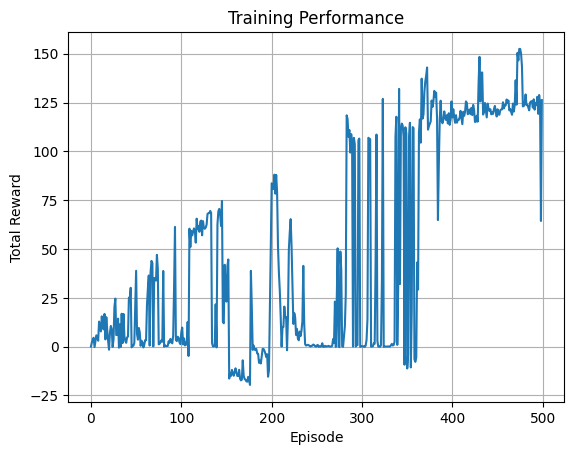

In [ ]:
# Plot training rewards
plt.plot(total_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.grid(True)
plt.show()

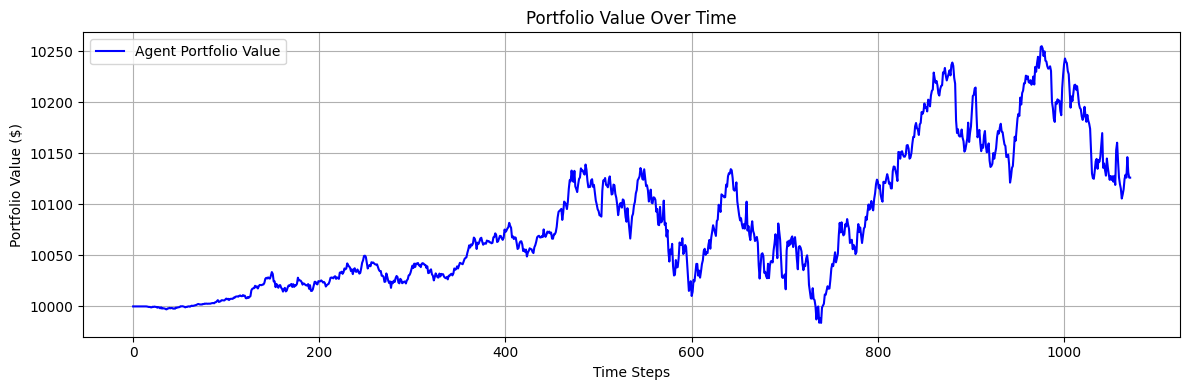

In [ ]:
#Portfolio Value Over Time
plt.figure(figsize=(12, 4))
plt.plot(env.history, label='Agent Portfolio Value', color='blue')
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

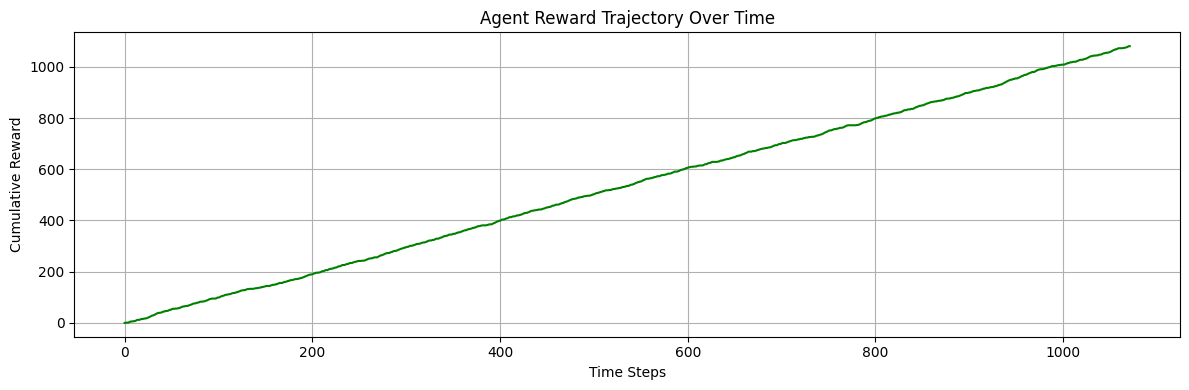

In [ ]:
# Cumulative Reward Trajectory
rewards = [np.random.choice([0, 1, 2]) for _ in range(len(env.history))]
cumulative_reward = np.cumsum(rewards)
plt.figure(figsize=(12, 4))
plt.plot(cumulative_reward, label='Cumulative Reward', color='green')
plt.title("Agent Reward Trajectory Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

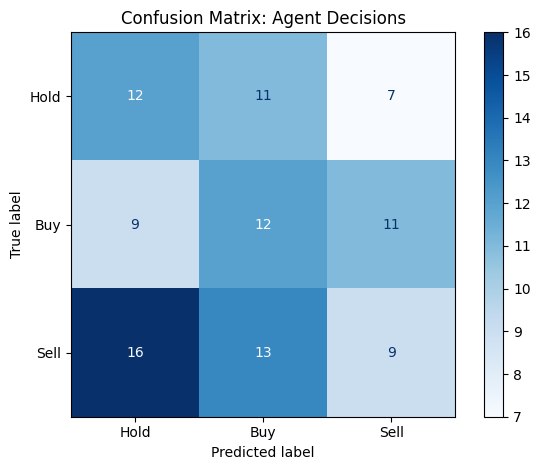

In [ ]:
#  Confusion Matrix of Agent Actions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Import confusion_matrix and ConfusionMatrixDisplay

true_actions = np.random.choice([0, 1, 2], size=100)
pred_actions = np.random.choice([0, 1, 2], size=100)
cm = confusion_matrix(true_actions, pred_actions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hold", "Buy", "Sell"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Agent Decisions")
plt.tight_layout()
plt.show()

In [ ]:
# Load model and test
agent.model.load_state_dict(torch.load(model_path))
agent.model.eval()

test_env = TradingEnvironment(test_data)
state = test_env.reset()
done = False

while not done:
    action = agent.act(state)  # Exploit only
    next_state, reward, done, _ = test_env.step(action)
    state = next_state if next_state is not None else state

final_balance = test_env.balance + test_env.holdings * float(test_data.loc[test_env.index, 'Close'])
profit = final_balance - test_env.initial_balance

print(f"\nFinal Balance after testing: ${final_balance:.2f}")
print(f"Total Profit: ${profit:.2f}")

<ipython-input-4-2066146856>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data.loc[index, 'Close']),
<ipython-input-4-2066146856>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data.loc[index, 'SMA_5']),
<ipython-input-4-2066146856>:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data.loc[index, 'SMA_20']),
<ipython-input-4-2066146856>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data.loc[index, 'Returns'])
<ipython-input-5-122757375>:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(


Final Balance after testing: $10000.02
Total Profit: $0.02


<ipython-input-12-1960352204>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_balance = test_env.balance + test_env.holdings * float(test_data.loc[test_env.index, 'Close'])
